In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import corner
import scipy.stats as stats

In [2]:
samples = pd.read_csv('examples_samples.csv')
samples.head()

,numax,dnu,teff,bp_rp,eps_p,d02,alpha_p,env_height,env_width,mode_width,H1_nu,H1_exp,H_power,H2_nu,H2_exp,d01
0,3.484414,2.135390,3.767956,0.802151,1.401072,0.979284,-3.080202,0.225126,2.456441,0.128703,3.298061,2.921364,2.848890,2.830882,4.041411,1.797920
1,3.493150,2.141782,3.756890,0.848493,1.482945,0.983385,-2.966572,0.536584,2.465763,0.094484,3.374310,3.515384,2.826130,2.836148,3.183972,1.809857
2,3.475558,2.123601,3.778466,0.750007,1.287302,0.970585,-2.788520,0.386517,2.501444,0.277879,3.394467,3.224052,2.804860,2.834453,2.820455,1.795310
3,3.489894,2.137486,3.758812,0.839171,1.458507,0.981102,-2.804012,0.649857,2.511151,0.144498,3.420310,3.855495,2.828574,2.846784,3.299784,1.807003
4,3.489919,2.138049,3.765160,0.813639,1.416170,0.982102,-2.896754,0.453859,2.513932,0.168972,3.399499,3.832885,2.830916,2.853358,3.834102,1.804794


In [3]:
class model():
    def __init__(self, nu):
        '''  The hard coded value of 20 is a massive fudge ... look at this! '''
        self.nu = nu
        self.N_p = np.arange(10, 30, 1)
        self.vis={'V20': 0.71, 'V10': 1.5}
        self.rv_factor = 20.0
    
    def model_(self, theta_u):
        
        
        # l=2,0
        modes, _ = self.addModes(**theta_u)
        
        # Background
        bkg = self.background(theta_u)
         
        return (modes * bkg) + bkg / self.rv_factor
    
    def addModes(self, d02, d01, mode_width, **kwargs):
         
        modes = np.zeros_like(self.nu)
        
        nu0_p = self.asymptotic_nu_p(**kwargs)

        Hs0 = self.envelope(nu0_p, **kwargs)

        for i, n in enumerate(self.N_p):

            # Adding l=0
            modes += self.lor(nu0_p[i], Hs0[i], mode_width) 
            
            # Adding l=2     
            H = Hs0[i] * self.vis['V20']
            f = nu0_p[i] - d02
            modes += self.lor(f, H, mode_width)
            
            # Adding l=1     
            H = Hs0[i] * self.vis['V10']
            f = nu0_p[i] + d01
            modes += self.lor(f, H, mode_width) 

        return modes, nu0_p
    
    def envelope(self, nu, env_height, numax, env_width, **kwargs):
        """ Power of the seismic p-mode envelope
    
        Computes the power at frequency nu in the oscillation envelope from a 
        Gaussian distribution. Used for computing mode heights.
    
        Parameters
        ----------
        nu : float
            Frequency (in muHz).
        hmax : float
            Height of p-mode envelope (in SNR).
        numax : float
            Frequency of maximum power of the p-mode envelope (in muHz).
        width : float
            Width of the p-mode envelope (in muHz).
    
        Returns
        -------
        h : float
            Power at frequency nu (in SNR)   
        """
    
        return self.gaussian(nu, 2*env_height, numax, env_width)
    
    def gaussian(self, x, A, mu, sigma):
        return A*np.exp(-(x-mu)**2/(2*sigma**2))
    
    def asymptotic_nu_p(self, numax, dnu, eps_p, alpha_p, **kwargs):
        """ Compute the l=0 mode frequencies from the asymptotic relation for
        p-modes
    
        Parameters
        ----------
        numax : float
            Frequency of maximum power of the p-mode envelope (muHz).
        dnu : float
            Large separation of l=0 modes (muHz).
        eps_p : float
            Epsilon phase term in asymptotic relation (unitless).
        alpha_p : float
            Curvature factor of l=0 ridge (second order term, unitless).
    
        Returns
        -------
        nu0s : ndarray
            Array of l=0 mode frequencies from the asymptotic relation (muHz).
            
        """
        
        n_p_max = numax / dnu - eps_p

        return (self.N_p + eps_p + alpha_p/2*(self.N_p - n_p_max)**2) * dnu
    
    def lor(self, nu0, h, w):
        """ Lorentzian to describe an oscillation mode.

        Parameters
        ----------
        nu0 : float
            Frequency of lorentzian (muHz).
        h : float
            Height of the lorentizan (SNR).
        w : float
            Full width of the lorentzian (muHz).

        Returns
        -------
        mode : ndarray
            The SNR as a function frequency for a lorentzian.
        """

        return h / (1.0 + 4.0/w**2*(self.nu - nu0)**2)
    
    def harvey(self, a, b, c):
        """ Harvey-profile

        Parameters
        ----------
        nu : np.array
            Frequency axis of the PSD.
        a : float
            The amplitude (divided by 2 pi) of the Harvey-like profile.
        b : float
            The characeteristic frequency of the Harvey-like profile.
        c : float
            The exponent parameter of the Harvey-like profile.

        Returns
        -------
        H : np.array
            The Harvey-like profile given the relevant parameters.
        """
         
        H = a / b * 1 / (1 + (self.nu / b)**c)

        return H

    def background(self, theta_u,):
        """
        Calculate the background model.

        Parameters
        ----------
        theta_u : dict
            A dictionary of background model parameters.
        nu : numpy.ndarray
            Array of frequency values.

        Returns
        -------
        array
            The calculated background model.

        Notes
        -----
        - Computes the Harvey components H1, H2, and H3 for the given frequency values.
        - Calculates the attenuation factor eta.
        - Combines the Harvey components with the attenuation factor and shot noise to
          compute the background model.
        """

        H1 = self.harvey(theta_u['H_power'], theta_u['H1_nu'], theta_u['H1_exp'],)

        H2 = self.harvey(theta_u['H_power'], theta_u['H2_nu'], theta_u['H2_exp'],)
        
        bkg = (H1 + H2)

        return bkg
    
    def make_timeseries(self):
        a = np.zeros_like(self.limit).astype(complex)
        a.real += self.limit**0.5 * np.random.randn(len(a))
        a.imag += self.limit**0.5 * np.random.randn(len(a))
        self.timeseries = np.fft.irfft(a)[:len(a)]
        self.times = np.fft.rfftfreq(len(a)*2 - 1, d=self.nu[1]/1e6)[:len(a)]
        print(self.times[:10])
    
    def __call__(self, params: dict):
        ''' Makes a power spectrum limit model
        
        params: dict
            A dictionary with a specific set of params that are ... 
        
        '''
        self.limit = self.model_(params)
        self.make_timeseries()
        return self.limit
    

In [52]:
nu = np.linspace(0, 15*8500, 500000)
pdict = {n: v for n, v in zip(samples.columns, samples.loc[100])}
exp_list=['dnu', 'numax', 'teff', 'd02', 'alpha_p', 'env_height', 'env_width', 'mode_width', 
          'H1_nu', 'H_power', 'H2_nu', 'd01']
for key in exp_list:
    pdict[key] = 10**pdict[key]
m = model(nu)
limit = m(pdict)

[ 0.          3.92156471  7.84312941 11.76469412 15.68625882 19.60782353
 23.52938824 27.45095294 31.37251765 35.29408235]


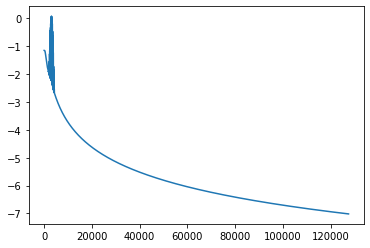

In [53]:
plt.plot(m.nu, np.log10(m.limit))

(2000.0, 3500.0)

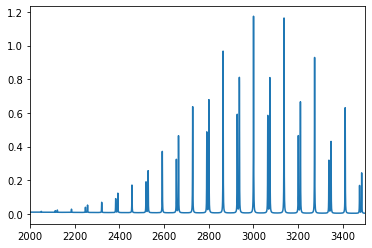

In [54]:
plt.plot(m.nu, (m.limit))
plt.xlim([2000, 3500])

(50000,)
1.3400429455656935


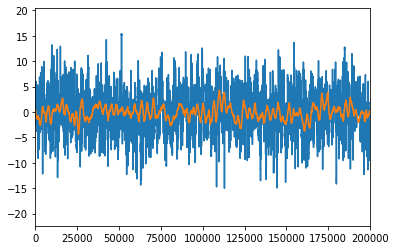

In [56]:
ts = m.timeseries * 100000
plt.plot(m.times, ts)
plt.xlim([0, 200000])
exposure = 1*10 # in cadences ... needs thought.
npts = len(m.timeseries)//exposure
integrated = np.mean(np.reshape(ts[:int(np.floor(npts*exposure))], [exposure, npts]), axis=0)
print(integrated.shape)
plt.plot(m.times[::exposure][:len(integrated)], integrated)
print(np.std(integrated))

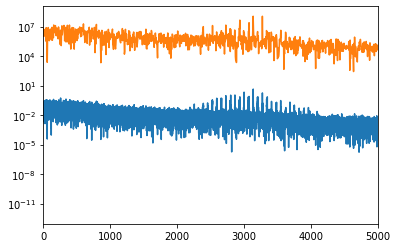

In [17]:
tmp = np.fft.rfft(m.timeseries)
tmp_int = np.fft.rfft(integrated)
f = np.fft.rfftfreq(len(tmp)*2-1, d=m.times[1])
f_int = np.fft.rfftfreq(len(tmp_int)*2-1, d=m.times[1])
plt.plot(f*1e6, tmp * np.conj(tmp))
plt.plot(f_int * 1e6, tmp_int * np.conj(tmp_int))
plt.xlim([0, 5000])
plt.yscale('log')

[0.         0.98039118 1.96078235 2.94117353 3.92156471 4.90195588
 5.88234706 6.86273824 7.84312941 8.82352059]
[1.17404413 0.83253398 0.66268849 0.58151412 0.51862919 0.47190169
 0.41717845 0.40819747 0.38127095 0.36382573 0.35535817 0.33478336
 0.32745998 0.30440858 0.30604497 0.2841519  0.29885831 0.29342054
 0.29705192 0.24677494 0.22899812 0.25651769 0.22948108 0.23333649
 0.2459121  0.22737922 0.19154506 0.18476857 0.1995748  0.20291629
 0.24370054 0.22598919 0.14928241 0.22554195 0.1808419  0.22836287
 0.15230749 0.2302032  0.2162649  0.18458576 0.14964149 0.14478847
 0.18633314 0.19570017 0.16044046 0.133541   0.13470598 0.16078194
 0.17147183 0.17924074 0.16865588 0.14508138 0.1375896  0.12342151
 0.14631403 0.12659674 0.20192596 0.15893176 0.10280446 0.13164896
 0.13648934 0.1887191  0.11159052 0.14895285 0.11509807 0.10723538
 0.11291407 0.15294628 0.08820581 0.12042924 0.12216433 0.13730743
 0.15089906 0.09730408 0.18069557 0.18963265 0.08959773 0.12184991
 0.13371951 0.14

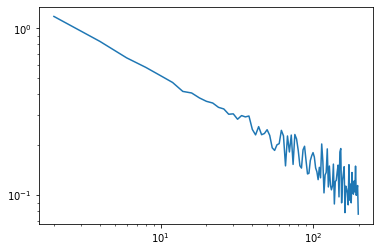

In [50]:
m.make_timeseries()
ts = m.timeseries * 80000

ints = np.arange(2, 200, 2)
std_dev = np.zeros(len(ints))
for idx, i in enumerate(ints):
    exposure = i # in cadences ... needs thought.
    npts = len(m.timeseries)//exposure
    integrated = np.mean(np.reshape(ts[:int(np.floor(npts*exposure))], [exposure, npts]), axis=0)
    std_dev[idx] = np.std(integrated)
    
plt.plot(ints, std_dev)
print(std_dev)
plt.xscale('log')
plt.yscale('log')